<a href="https://colab.research.google.com/github/SalehMehrabani/PyTorch-Deep-Learning/blob/main/CNN2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Convolutional Neural Network  - CNN
* Omniglot Dataset


In [31]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

import torch
from torch import nn

from torch.utils.data import Dataset, DataLoader

import torchvision
from torchvision import datasets
from torchvision  import transforms
from torchvision.transforms import ToTensor


In [32]:
from sklearn.model_selection import train_test_split

In [33]:
from torchvision.datasets.folder import DatasetFolder

In [34]:
from tqdm.auto import tqdm

In [35]:
device= "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

##Create Required Functions

In [36]:
import requests
from pathlib import Path 

# Download helper functions from Learn PyTorch repo (if not already downloaded)
if Path("helper_functions.py").is_file():
  print("helper_functions.py already exists, skipping download")
else:
  print("Downloading helper_functions.py")
  # Note: you need the "raw" GitHub URL for this to work
  request = requests.get("https://raw.githubusercontent.com/mrdbourke/pytorch-deep-learning/main/helper_functions.py")
  with open("helper_functions.py", "wb") as f:
    f.write(request.content)

helper_functions.py already exists, skipping download


In [37]:
from helper_functions import accuracy_fn

In [38]:
from timeit import default_timer as timer 
def print_train_time(start: float, end: float, device: torch.device = None):
    
    total_time = end - start
    print(f"Train time on {device}: {total_time:.3f} seconds")
    return total_time


In [39]:
def eval_model(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               accuracy_fn,
               device: torch.device = device):
  loss, acc= 0, 0
  model.eval()
  with torch.inference_mode():
    for X, y in data_loader:
      #Put the data on the same device
      X, y= X.to(device), y.to(device)
      #Forward Propagation
      y_pred = model(X)
      # Loss/ Accuracy Function
      loss += loss_fn(y_pred, y)
      acc += accuracy_fn(y ,y_pred.argmax(dim=1))
    
    # Calculate average loss and accuracy per batch
    loss /= len(data_loader)
    acc /= len(data_loader)
  return {"model_name": model.__class__.__name__, # only works when model was created with a class
          "model_loss": loss.item(),
          "model_acc": acc}

In [40]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device =device):
  
  train_loss, train_acc = 0, 0

  #Put Model into training mode
  model.train()

  for batch, (X, y) in enumerate(data_loader):

    #Put Data on target device
    X, y = X.to(device), y.to(device)

    #Forward propagation
    y_pred = model(X)

    #Loss Function (per batch)
    loss = loss_fn(y_pred, y)
    train_loss += loss

    #Accuaray Function (per batch)
    train_acc += accuracy_fn(y_true=y, 
                           y_pred=y_pred.argmax(dim=1))

    #Optimizer zero grad
    optimizer.zero_grad()

    #Loss backpropagation
    loss.backward()

    #optimizer step
    optimizer.step()
  
  #Calculate the average train loss and accuracy
  train_loss /= len(data_loader)
  train_acc /= len(data_loader)

  #Print out the result of training loop
  print(f'Train loss: {train_loss:.5f} | Train acc: {train_acc:.5f}')

In [41]:
def test_step(model: torch.nn.Module,
              data_loader: torch.utils.data.DataLoader,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):

  test_loss, test_acc= 0, 0

  #Put the model on testing mode
  model.eval()

  with torch.inference_mode():
    for (test_X, test_y) in (data_loader):

      #Put the data on the same device:
      test_X, test_y = test_X.to(device), test_y.to(device)

      #forward Propagation
      test_pred = model(test_X)

      #Loss Function
      test_loss += loss_fn(test_pred, test_y)

      #Accuacy Function
      test_acc += accuracy_fn(y_true=test_y,
                             y_pred=test_pred.argmax(dim=1) )
      
    #Calculate the average test loss / accuracy
    test_loss /= len(data_loader)
    test_acc /= len(data_loader)

    #Print out the result of testing loop
    print(f"Test loss: {test_loss:.5f} | Test acc: {test_acc:.5f}")

## Setup Training and Testing datasets

In [42]:
#Setup data
data = datasets.Omniglot(
    root = "data",
    download = True,
    transform = torchvision.transforms.ToTensor(),
    target_transform = None
)
len(data), data[200]

Files already downloaded and verified


(19280, (tensor([[[1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           ...,
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.],
           [1., 1., 1.,  ..., 1., 1., 1.]]]), 10))

In [43]:
train_data, test_data = train_test_split(data, test_size=0.2, random_state= 42, shuffle= True)
len(train_data), len(test_data)

(15424, 3856)

In [44]:
labels=set()
for i in range(len(data)):
  image,label= data[i]
  labels.add(label)

In [45]:
image.shape

torch.Size([1, 105, 105])

(-0.5, 104.5, 104.5, -0.5)

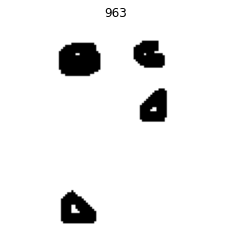

In [46]:
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
plt.axis(False)

In [47]:
#Setup training dataloader
train_dataloader = DataLoader(
    dataset = train_data,
    batch_size = 32,
    shuffle = True
)

#Setup testing dataloader
test_dataloader = DataLoader(
    dataset = test_data,
    batch_size = 32,
    shuffle= True
)

## Create Model 

In [53]:
class OmniglotModel(nn.Module):
  def __init__(self,
               input_shape: int, 
               hidden_units: int,
               output_shape: int):
    super().__init__()
    self.conv_block1= nn.Sequential(
        nn.Conv2d(
            in_channels= input_shape,
            out_channels= hidden_units,
            kernel_size= 3,
            stride= 1,
            padding= 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            in_channels= hidden_units, 
            out_channels= hidden_units,
            kernel_size= 3,
            stride= 1,
            padding= 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2)
    )
    self.conv_block2= nn.Sequential(
        nn.Conv2d(
            in_channels= hidden_units,
            out_channels= hidden_units,
            kernel_size= 3,
            stride= 1,
            padding= 0
        ),
        nn.ReLU(),
        nn.Conv2d(
            
            in_channels= hidden_units,
            out_channels= hidden_units,
            kernel_size= 3,
            stride= 1,
            padding= 0
        ),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size= 2)
    )
    self.classifier= nn.Sequential(
        nn.Flatten(),
        nn.LazyLinear(out_features= output_shape)
    )
  def forward(self, x):
    x= self.conv_block1(x)
    x= self.conv_block2(x)
    x= self.classifier(x)
    return(x)


In [55]:
model_1= OmniglotModel(input_shape= 1,
                       hidden_units= 10,
                       output_shape= 963).to(device)

In [56]:
model_1

OmniglotModel(
  (conv_block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (conv_block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): LazyLinear(in_features=0, out_features=963, bias=True)
  )
)

In [57]:
loss_fn = torch.nn.CrossEntropyLoss()
optimizer= torch.optim.Adam(model_1.parameters(), lr=1e-3)

In [ ]:
torch.manual_seed(42)

from timeit import default_timer as timer
train_time_start_model_1 = timer()

epochs = 20

for epoch in tqdm(range(epochs)):
  print(f"Epoch: {epoch}\n---------")
  train_step(
      model = model_1,
      data_loader = train_dataloader,
      loss_fn = loss_fn,
      optimizer = optimizer,
      accuracy_fn = accuracy_fn,
      device = device
  )
  test_step(
      model = model_1,
      data_loader = test_dataloader,
      loss_fn = loss_fn,
      accuracy_fn = accuracy_fn,
      device = device
  )
train_time_end_model_1 = timer()

total_train_time_model_2 = print_train_time(
    start = train_time_start_model_1,
    end = train_time_end_model_1,
    device = device
)

In [ ]:
model_1_results = eval_model(
    model= model_1,
    data_loader = test_dataloader,
    loss_fn = loss_fn, 
    accuracy_fn = accuracy_fn, 
    device = device
)
model_1_results